# Example for an excited state calculation

Short example of how to form the objectives for the ''hangman's'' approach to excited states.  
Here the states are sequentially computed and are kept orhogonal towards previous states by projection.  

The method was for example applied in:
https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.8b01004

The overlap objective is formed from the quantum circuits of the optimized lower lying states $U_i$ and the current parametrized circuit $U(a)$ like this:

$$
S_i^2(a) = \|\langle \Psi_i \rvert \Psi(a) \rangle\|^2 = \|\langle 0 \rvert U_i^\dagger U(a) \lvert 0 \rangle\|^2 = 
 \langle 0 \rvert U^\dagger(a) U_i  P_0 U_i^\dagger U(a) \lvert\rangle = \langle P_0 \rangle_{U_i^\dagger U(a)} $$
 
where $P0 = \lvert 0..0 \rangle \langle 0..0 \rvert = \frac{1}{2^n} \otimes_n (1 + Z(n))$.

Bound states can then be kept orthogonal by projecting lower lying states out which is equivalent as minimizing the objective:

$$
 L = \langle H \rangle_{U(a)} - E_i S_i^2(a)
$$


We will use an active space Beryllium Hydride molecule with two orbitals because the circuit template is easy to construct for this example and it executes fast.

<img src="data/ex_solver_cartoon-1.png" width="200" height="200" />

In [6]:
geomstring="be 0.0 0.0 0.0\nh 0.0 0.0 {R}\nh 0.0 0.0 -{R}"

In [37]:
import tequila as tq

fci_gs = []
fci_es = []
energies_gs = []
energies_es = []
P0 = tq.paulis.Projector("|00>")
for R in [0.7 + 0.1*i for i in range(25)]:
    active = {"b1u": [0], "b2u": [0]}
    mol = tq.chemistry.Molecule(geometry=geomstring.format(R=R), basis_set="6-31g", active_orbitals=active)
    H = mol.make_hamiltonian()
    results = []
    for i in range(2):
        U = tq.gates.Ry((i, "a"), 0)
        U += tq.gates.CNOT(0, 1) + tq.gates.CNOT(0, 2)
        U += tq.gates.CNOT(1, 3) + tq.gates.X([2, 3])
        E = tq.ExpectationValue(U, H)
        active_vars = E.extract_variables()
        angles = {angle: 0.0 for angle in active_vars}
        for data, U2 in results:
            S2 = tq.ExpectationValue(H=P0, U=U2.dagger() + U)
            E -= data.energy * S2
            angles = {**angles, **data.angles}

        result = tq.optimizer_scipy.minimize(E, method="bfgs", variables=active_vars, initial_values=angles)
        results.append((result, U))
    energies_gs.append(results[0][0].energy)
    energies_es.append(results[1][0].energy)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -14.159139614214082  angles= {(0, 'a'): 0.0}  samples= None
E= -14.159293307752835  angles= {(0, 'a'): -0.01117563247680664}  samples= None
E= -14.160483617508682  angles= {(0, 'a'): -0.0558781623840332}  samples= None
E= -14.174381737949034  angles= {(0, 'a'): -0.23468828201293945}  samples= None
E= -14.361136888135027  angles= {(0, 'a'): -0.9499287605285645}  samples= None
E= -14.975132106061876  angles= {(0, 'a'): -3.8108906745910645}  samples= None
E= -15.012797414115823  angles= {(0, 'a'): -2.563770588444879}  samples= None
E= -15.081685391835627  angles= {(0, 'a'): -3.12

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -14.959362656345169  angles= {(0, 'a'): 0.0}  samples= None
E= -14.95951777931364  angles= {(0, 'a'): -0.011423587799072266}  samples= None
E= -14.960630356872619  angles= {(0, 'a'): -0.05711793899536133}  samples= None
E= -14.972886541150773  angles= {(0, 'a'): -0.23989534378051758}  samples= None
E= -15.133191604312694  angles= {(0, 'a'): -0.9710049629211426}  samples= None
E= -15.604211779589527  angles= {(0, 'a'): -3.8954434394836426}  samples= None
E= -15.65883821358828  angles= {(0, 'a'): -2.5616206745920915}  samples= None
E= -15.714418106996428  angles= {(0, 'a'): -3.1

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -15.113864356134023  angles= {(0, 'a'): 0.0}  samples= None
E= -15.113996235559847  angles= {(0, 'a'): -0.010671138763427734}  samples= None
E= -15.11488352159419  angles= {(0, 'a'): -0.05335569381713867}  samples= None
E= -15.12414353715464  angles= {(0, 'a'): -0.22409391403198242}  samples= None
E= -15.243689642254635  angles= {(0, 'a'): -0.9070467948913574}  samples= None
E= -15.702988689905023  angles= {(0, 'a'): -3.6388583183288574}  samples= None
E= -15.704502942794889  angles= {(0, 'a'): -2.5863949708377305}  samples= None
E= -15.74656111441811  angles= {(0, 'a'): -3.10

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -15.098681639896649  angles= {(0, 'a'): 0.0}  samples= None
E= -15.098766676797394  angles= {(0, 'a'): -0.008657455444335938}  samples= None
E= -15.099308402854176  angles= {(0, 'a'): -0.04328727722167969}  samples= None
E= -15.104682867329755  angles= {(0, 'a'): -0.1818065643310547}  samples= None
E= -15.174137952480658  angles= {(0, 'a'): -0.7358837127685547}  samples= None
E= -15.63379262897217  angles= {(0, 'a'): -2.9521923065185547}  samples= None
E= -15.192319633222057  angles= {(0, 'a'): -5.3901317596435545}  samples= None
E= -15.636983852632065  angles= {(0, 'a'): -3.0

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -15.03878452481597  angles= {(0, 'a'): 0.0}  samples= None
E= -15.03883474257104  angles= {(0, 'a'): -0.006680488586425781}  samples= None
E= -15.039147321430534  angles= {(0, 'a'): -0.033402442932128906}  samples= None
E= -15.0421789663622  angles= {(0, 'a'): -0.1402902603149414}  samples= None
E= -15.081677720108889  angles= {(0, 'a'): -0.5678415298461914}  samples= None
E= -15.45699518269987  angles= {(0, 'a'): -2.2780466079711914}  samples= None
E= -15.53001371764071  angles= {(0, 'a'): -9.118866920471191}  samples= None
E= -15.19616968711777  angles= {(0, 'a'): -36.482148

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -14.961441894786706  angles= {(0, 'a'): 0.0}  samples= None
E= -14.9614676012602  angles= {(0, 'a'): -0.004783153533935547}  samples= None
E= -14.961626976907183  angles= {(0, 'a'): -0.023915767669677734}  samples= None
E= -14.963167711725717  angles= {(0, 'a'): -0.10044622421264648}  samples= None
E= -14.983487089443988  angles= {(0, 'a'): -0.4065680503845215}  samples= None
E= -15.228339354608444  angles= {(0, 'a'): -1.6310553550720215}  samples= None
E= -14.970038149350362  angles= {(0, 'a'): -6.5290045738220215}  samples= None
E= -15.430505500797125  angles= {(0, 'a'): -2.

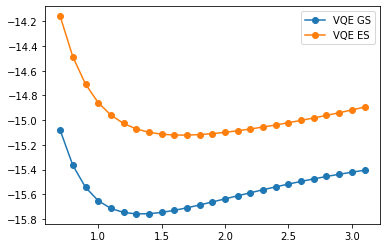

In [38]:
import matplotlib.pyplot as plt
R =  [0.7 + 0.1*i for i in range(len(energies_gs))]
plt.figure()
plt.plot(R, energies_gs, marker="o", label="VQE GS")
plt.plot(R, energies_es, marker="o", label="VQE ES")
plt.legend()
plt.show()